# Generating CAPTCHA images with Diffusion Models
#### DTSA 5511 Intro to Deep Learning

## Problem Statement

For the final project in the course I will be creating a diffuion model which will generate CAPTCHA images. The dataset used for modeling comes from the Kaggle dataset [Captcha Images](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images), CAPTCHA stands for (Completely Automated Public Turing test to tell Computers and Humans Apart). Although the CAPTCHA images are breakable by AI bots now, it is useful as a stepping stone for generating more complicated test like CAPTHCA which AI bots can't break, using diffusion models. I will be creating the diffution model form the 2020 paper [Denoising Diffusion Probabilistic Models (DDPM)](https://arxiv.org/pdf/2006.11239.pdf) which uses a U-Net with Residual blocks and self-attention blocks. 

## Github Repository

https://github.com/jagrat89/captchaDiffusion

## Import

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import gelu
from tensorflow.nn import silu
import tensorflow as tf
from tensorflow import config
from tensorflow.keras import losses
from PIL import Image
import os
from tqdm import tqdm
from tensorflow.keras.optimizers import AdamW
from tensorflow import config

### Initializing the GPU

I am using a kaggle notebook with GPU P100 accelerator. I will be using the tf.distribute.MirroredStrategy to explicitly use the GPU. I will configure GPU memory to be allocated on demand instead of allocating all of it from the start using the set_memory_growth function.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


## EDA and Data Visualisation

### Reading in the Images

I will transform the image values to be between -1 and 1.

In [3]:
image_dir = '/kaggle/input/captcha-version-2-images/samples/'
list_ds = tf.data.Dataset.list_files(str(image_dir + '*.png')) 
def process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

images_ds = list_ds.map(process_path)

### Dimension of the images

The dimension of the image are 50 x 200 x 3

In [4]:
for image in images_ds.take(1):
    print(image.shape)

(50, 200, 3)


### Defining the Config variables and creating the dataset for modeling

I have kept the batch size equal to 4 after some experiments. Any value higher than 4, crashes the notebook because the GPU runs out of memory.

In [29]:
IMAGE_SIZE = (50,200, 3)
BATCH_SIZE = 4
dataset = images_ds.batch(BATCH_SIZE)

### Visualising the images

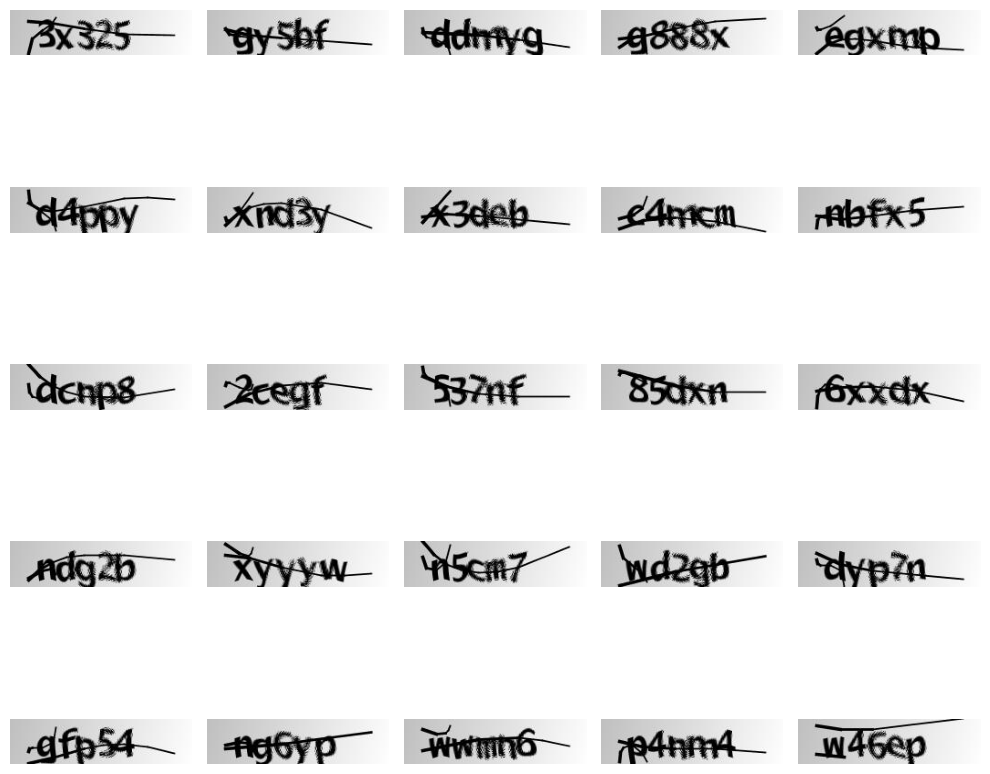

In [6]:
# Extract images from the dataset
images = [img.numpy() for img in images_ds.take(25)]

def plot_images(x):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(x):
        img = (img * 0.5 + 0.5) 
        plt.subplot(5, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_images(images)

## Modeling


### Diffuision Model

As described earlier I will be using a diffusion model to generate CAPTCHA images. In this section I will briefly describe what denoising diffusion probablistic models is and its architecture. 

#### What do Denoising Diffusion Probabilistic Models do?

The diffusion model has two processes __Forward Diffusion__ and __Reverse Diffusion__. Both of these processes happen over a specified numer of time-stpes, in this project it is 1000. 

1. __Forward Diffusion__: The forward diffusion process starts with the original image and adds noise sampled from a normal distribution to the image from previous time-step at each time-step, the original image is the input to the first time-step. In 1000 steps for example the image is total noise and has no features left from the original image, and distribution of the image becomes the standard normal distrubution. An example of forward diffusion process is give below.
The [source](https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/) of the image.

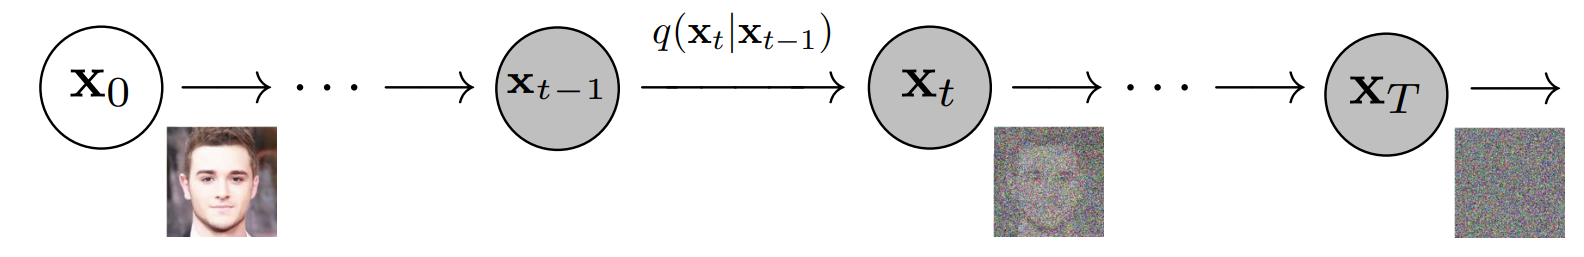


The progression shown including X(0) to X(T) is the forward diffusion process, in this project the total timestep T will be T = 1000 . The forward diffusion process is a very simple process where we keep on adding the noise for 1000 time-steps, and one optimization in the paper removes the need to go through all the 1000 steps sequentially, we can directly calculate the fully noised image from the original image meaning directly X(1000) from X(0).

2. __Reverse Diffusion__: This process is the reverse of the forward process it starts from the ouput of the forward process and iteratively removes all the noise of the image to recreate the original image. It does this in 1000 steps. Below is an example of the reverse diffusion proccess from [source](https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/).

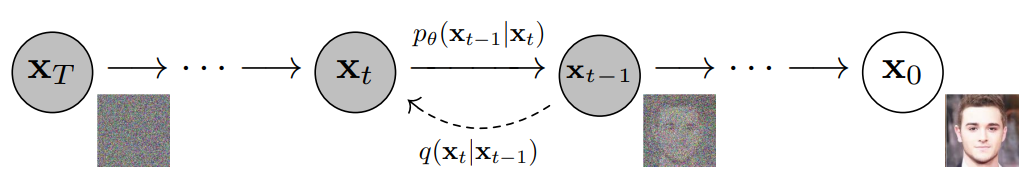

The reverse diffusion process starts with X(T = 1000) to X(0) which should yield the original image from the noised image. The reverse diffusion process needs a model which predicts how much noise there is in the image of the forward time-step and remove it from the image, and keep on doing this until we find back the original image. Here is another graphic which explains both process, from [source](https://learnopencv.com/denoising-diffusion-probabilistic-models/). 

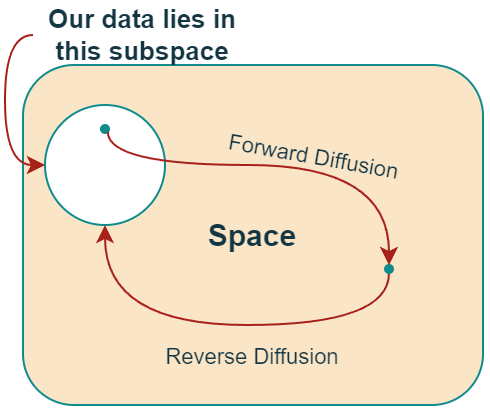

The reverse diffusion process is implemented with a U-Net Model. Below is an image of the full process followed in diffusion with it's equations, from [source](https://learnopencv.com/denoising-diffusion-probabilistic-models/). 

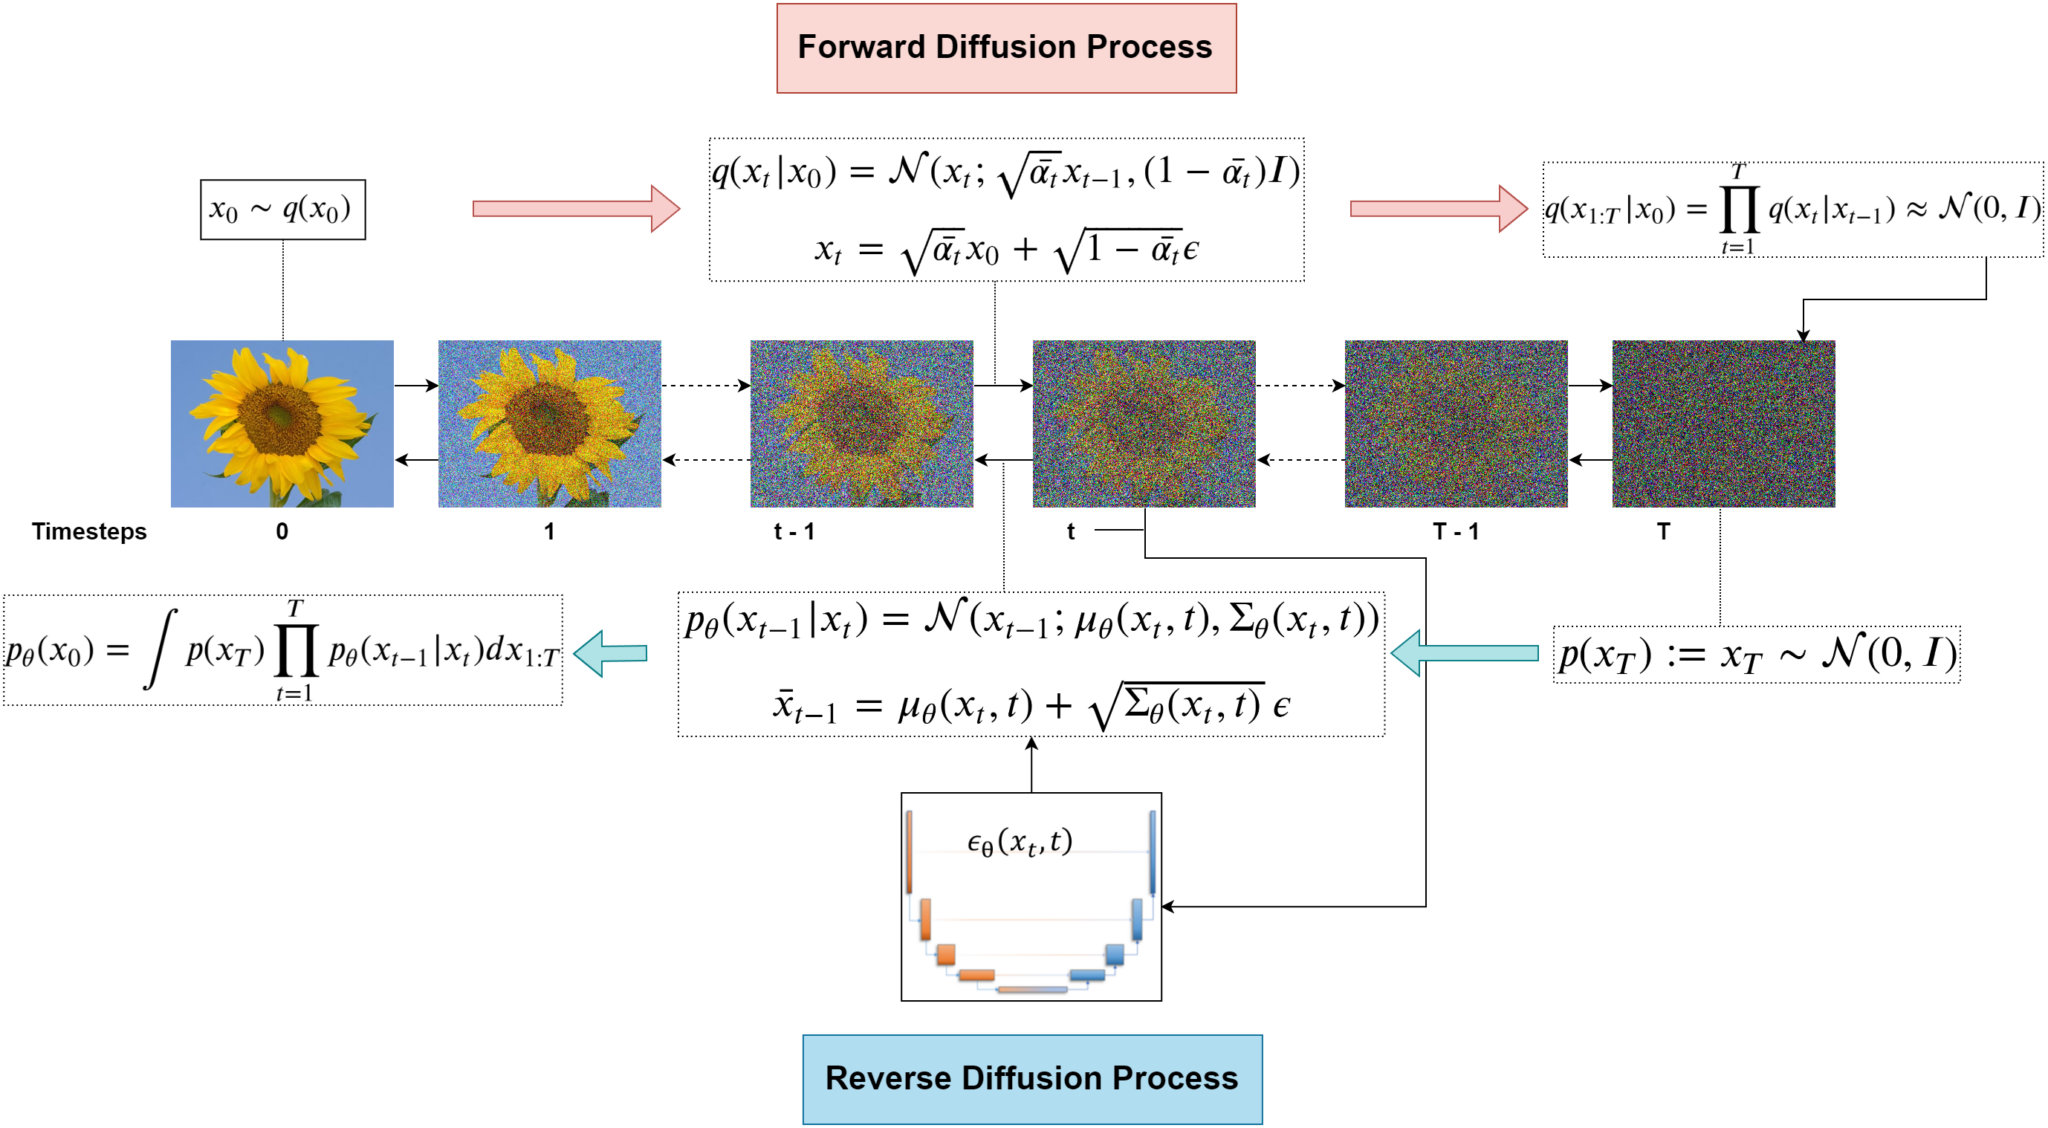



#### Diffusion Model Architecture

The components used in the Diffusion Model architecture are as follows:
 1. __Convolution Blocks:__ This blocks have two convolution layers in them and they use GroupNormalization and GELU activation after every convolution, the block also have residual connections inspired from ResNet. The convolutions filters are 3 x 3 and uses the "same" padding, meaning the input and ouput spatial dimensions of the ConvBlocks will remain the same.  
 
 2. __Down Sampling:__ The job of the Downsampling layer is to reduce the spatial dimension of the image and increase the number of filters. For example if I downsample a 50x200x64 image the output will be 25x100x128. The DownSampling block also adds something called as the time-embedding to the feature maps.
 
 3. __Up Sampling:__ The Up Sampling block is the opposite of the Downsampling block, it reduces the number of filters of the input and increase the saptial dimensions. For example if I UpSample a 25x50x128 image the ouput of the layer will be 50x100x64. It also adds the time-embedding the ouput of the convolution layers.
 
 4. __Self Attention Layer:__ I will only give a brief intro to what the layer does here, Please look at the Attention section of [MIT 6.S191: Recurrent Neural Networks, Transformers, and Attention Lecture
](https://www.youtube.com/watch?v=ySEx_Bqxvvo&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=2&t=2890s) for a detailed explanation. In essence, an attention layer computes weighted combinations of its input features based on their inter-relationships. While it's often described as "highlighting salient parts", this is a metaphorical way of saying it focuses more on certain features based on their importance in a given context. The Attention layer is used after each DownSample and UpSample for this implementation. The Attention layer uses Key, Query and Value matrix, the Query basically is the mathematical form of a question representing what it needs to pay attention, the Key is the answer containing what the image has, we multiply the Query and Key matrix to calculate how much information does one pixel need from all of the other pixel, once we have this information we multiply the ouput of the (Query x Key) with the Value matrix which represents the actual values of the image and yields the final output of the attention layer.



5. __U-Net Model:__ The U-Net Model consists of all the components described above, in a particualer manner. The models job is to predict the amount of noise in the image. The architecuture U-Net Model used in the paper has been shown below from [source](https://learnopencv.com/denoising-diffusion-probabilistic-models/):

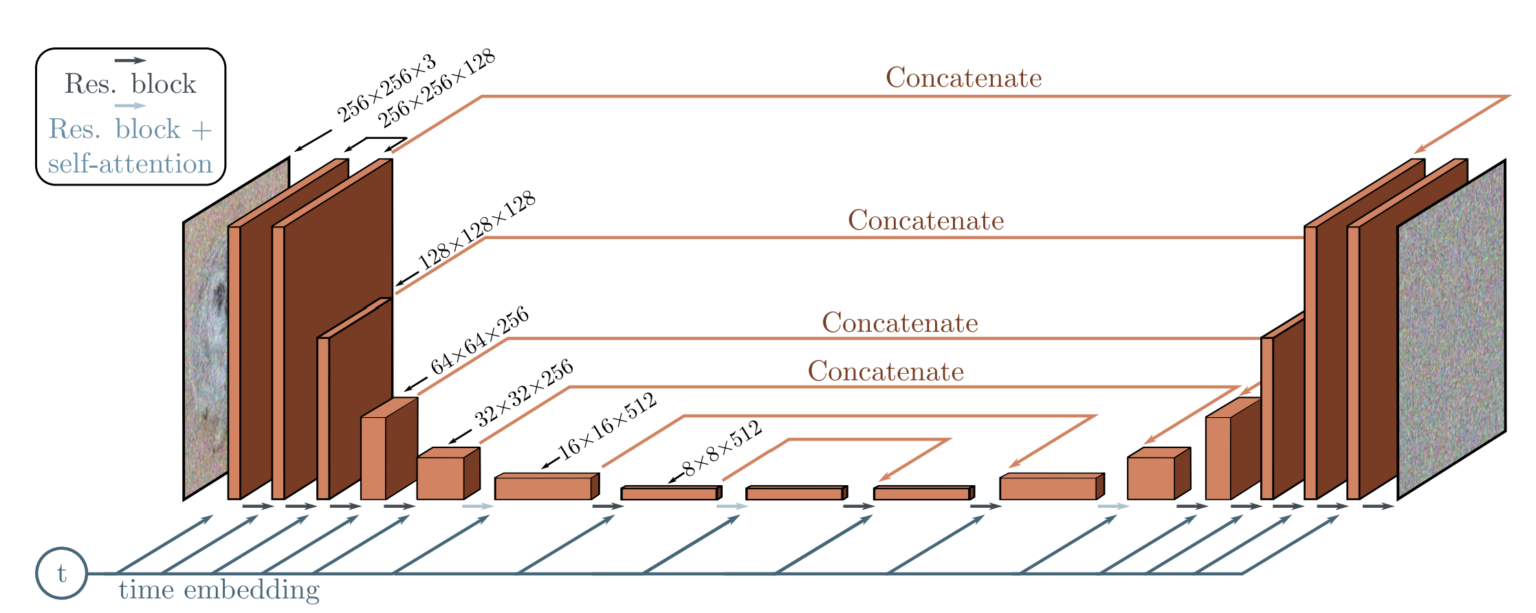

The __Changes__ between architecture shown in the image and the model used in this project are as follows:

1. I use Self-Attention after every DownSampling and UpSampling.
2. The other difference is the spatial dimensions of the image which start from 50 x 200 instead of 256 x 256  shown in the picture.
3. I use a Convolution block in the first layer for increasing the filter dimension of the image from (50 x 200 x 3) to (50 x 200 x 64) after this layer the architecture is similar to the one shown in the image with minute changes. 

I will discuss more details of model architecture as we go on implementing the model. 

## Implementation

### Convolution Block

The convolution block is made up of two Convolutions and it uses the GroupNormalization and GELU activation after each convolution. The Convolution Block can optionally be configured with residual connection based on the res_block parameter. 
The convolutions have filters of size __(3 x 3)__ and the number of channels are decided by the output_channels and the mid_channels parameters. The __mid_channels__ are used for the first convolution and the __output_channels__ are used for the second convolution, the convolutions are configured with __padding = "same"__ which means that the input spatial dimension and the ouput spatial dimensions will be the same, only change will be the number of channels.

A breif Explanation of Group Normalization and GELU activation:

1. __Group Normalization:__ Group normalization was introduced as an alternative for Batch Norm because, batch norm was very senstive to smaller batch sizes and the error rate increased while using batch norm with small batches compared to batch of 32. As an alternative Group Norm, normalizes the input across the channels by dividing them in specified groups and calculating the normalized values for each group differently. In this case we are going to use Group Normalization whith __"groups = 1"__ which will normalize across all the channels insted of breaking it into smaller groups, this makes the calculations effectively same as Layer Normalization. I highly recommend watching this short explanation of Group Norm [Group Normalization | Lecture 42 (Part 2) | Applied Deep Learning](https://www.youtube.com/watch?v=uTyPHdq_VDs).

2. __GELU:__ GELU stands for Gaussian Error Linear Unit. In essence GELU activation is a non-linear activaton function which is similar to ReLU and also has properties like sigmoid or tanh functions. GELU has been shown to give better results in transformer architectures. For a detailed explanation please look at this video explaining GELU activation [Neural Networks From Scratch - Lec 15 - GeLU Activation Function](https://www.youtube.com/watch?v=kMpptn-6jaw).

In [22]:
def ConvBlock(x, output_channels, mid_channels = None, res_block = False):
    if not mid_channels:
        mid_channels = output_channels
    o = layers.Conv2D(mid_channels, (3,3), padding = "same", use_bias = False)(x)
    o = layers.GroupNormalization(groups=1)(o)
    o = gelu(o)

    o = layers.Conv2D(output_channels, (3,3), padding = "same", use_bias = False)(o)
    o = layers.GroupNormalization(groups=1)(o)

    if res_block:
        o = gelu(x + o)

    return o

### Down Sampling Block

The DownSample function also contains ConvBlocks applied after downsampling the input of the last layer. The downsampling is performed by applying a __(2 x 2) MaxPool Layer__, which will reduce the saptial dimensions by half. After that the two convolution block applied after downsampling have one difference between them, the first block uses a residual connection and the second block doesn't. After the convolutions, the timestep information is encoded in the convolution output, meaning the the timestep of the input image which can be anything between 0 - 1000, each timestep is represented using a 256 dimension embedding which we will discuss afterwards, this 265-dimension time-step is first sent through an SILU (Sigmoid Linear Unit) activation function to introduce non-linearity and then through a linear layer which makes it's dimension equal to number of channels the image feature map has after the convolutions, after that each value in the output_channel dimension of t tensor is broadcasted to be the same as height and width of the image, so the __t tensor__  dimensions after reshpaing are __height of image x width of image x output_channels__ . This t tensor is added to the feature map to encode it with the time-step representation.

In [23]:
def DownSample(x, t, input_channels, output_channels):
    # Downsample
    x = layers.MaxPool2D(2)(x)
    
    # Apply convolution
    x = ConvBlock(x, input_channels, res_block = True)
    x = ConvBlock(x, output_channels)
    
    # Apply SILU activation to time-step embedding
    t = silu(t)
    
    # Feed it to FC layer
    t = layers.Dense(output_channels)(t)
    
    # Add extra dim to t
    t = tf.expand_dims(t, 1)
    height, width = x.shape[1], x.shape[2]
    
    # Resahpe t to equate it to the size of x
    t = layers.UpSampling2D(size=(height, width))(t)
    
    # Add the time-step embedding to the image
    return layers.Add()([x, t])

### Up Sampling Block

In the upsampling block we do the opposite of downsample and double the spatial dimension of the input. 
1. The upsampling is performed in tf.image_resize. 
2. The upsampled image is concatenated with an image of same dimensions form the downsample layers, please refer to the visual of the architecture for a better understanding. Both Images are concatenated along their channels which is axis = -1 in tf.
3. The concatenated ouput is then put through two convblocks where the first one uses a residual connection and the second one doesn't, the second convblock uses half the input_channels as mid_channels.
4. The rest is the same procedure of encoding the image with the time embeddings discussed in the downsample section.

In [24]:
def UpSample(x, skip_x, t, input_channels, output_channels):
    # Calculate the new height and width of the image
    new_height = x.shape[1] * 2
    new_width = x.shape[2] * 2 
    
    # Special case for when upsampling from a height of 12 
    # The height has to be 25 to match the residual height which will be 25
    if new_height == 24:
        new_height += 1
        
    # Increasing the spatial dimensions of the image
    x = tf.image.resize(x, [new_height, new_width], method="bilinear")
    
    # Concatenate Image skip_x is an image from downsample layers
    x = tf.concat([skip_x, x], axis=-1)
    
    # Convolutions
    x = ConvBlock(x, input_channels, res_block = True)
    
    # Convolutions with mid_channels as half the input_channels
    x = ConvBlock(x, output_channels, input_channels // 2)
    
    # Apply SILU activation to time-step embedding
    t = silu(t)
    
    # Feed it to FC layer
    t = layers.Dense(output_channels)(t)
    
    # Add extra dim to t
    t = tf.expand_dims(t, 1)
    height, width = x.shape[1], x.shape[2]
    
    # Resahpe t to equate x
    t = layers.UpSampling2D(size=(height, width))(t)
    
    return layers.Add()([x, t])

### Self-Attention

The self-attention mechanism has been provided in Keras as the MuliHeadAttention Layer, where each __Head__ has a Query, Key and Value which it processes please see the details below. The SelfAttention Layer has been implemented in the following way:
1. The input image is reshaped from (Batch, Height, Width, Channels) to (Batch, Height x Width, Channels) the image is reshaped because the Attention mechanism calculates what each pixel across all the channels, need from the other pixel across all the channels.
2. The reshaped input is fed into the __LayerNormalization__, this is done before applying the Attention mechanism, becuase it was shown to give better results.
3. The MultiHeadAttention gets the __num_heads=4__ meaning the image input channels will be divided in __channels / 4__,  each head will get __(Batch, Height x Width, Channels / 4)__ as input, the output of all the four head is concatenated before returning it so the output of the Multi-Head Attention will be __(Batch, Height x Width, Channels)__.
4. The original input is added to the newly processed attention output.
5. The attenion ouput is passed through Layer Norm.

__6 - 9.__ The ouput of the Layer Norm is passed through a FC layer then GELU activation then again a FC Layer.

7. The New output is added with the original attention value. Which produces the final self-attention value.


The architecture of the self-attention mechanism was first introduced in this paper [Attention Is All you Need](https://arxiv.org/pdf/1706.03762.pdf). The only difference in the implementation from the paper is the way we use Layer Norm, the paper uses layer norm after calculating the attention value instead of before.

I highly recommend Andrej Karpathy videos on GPT, Transformers and SelfAttention for getting a clear understanding of how self-attention works, if you're not already aware of it [Let's build GPT: from scratch, in code, spelled out.
](https://www.youtube.com/watch?v=kCc8FmEb1nY).

In [25]:
def SelfAttention(x, channels, size):
    # Reshaping the input x from for example (4, 25, 100, 256) -> (4, 2500, 256)
    x = tf.reshape(x, (-1, size[0] * size[1], channels))
    
    # Layer Normalization
    # This will calculate normalization scores for each image differently 
    x = layers.LayerNormalization(axis=-1)(x)
    
    # The MultiHeadAttention Layer from keras takes three inputs the Query, Key and Value
    attention_value = layers.MultiHeadAttention(num_heads=4, key_dim=channels, value_dim = channels)(x, x, x)
    
    # Skip Connection with input
    attention_value = attention_value + x

    # Layer Norm
    temp_atten = layers.LayerNormalization(axis=-1)(attention_value)
    
    # FC Linear layer
    temp_atten = layers.Dense(channels)(temp_atten)
    
    # GELU Activation function
    temp_atten = gelu(temp_atten)
    
    # FC Linear layer
    temp_atten = layers.Dense(channels)(temp_atten)
    
    # Skip Connection
    attention_value = attention_value + temp_atten
    
    # Reshpe back to the dimensions of input for example (4, 2500, 256) -> (4, 25, 100, 256)
    attention_value = tf.reshape(attention_value, (-1, size[0], size[1], channels))
    return attention_value

### Sinusoidal Positional Encoding

The Postitional Encoding used in this implementation was devised in the [Attention Is All you Need](https://arxiv.org/pdf/1706.03762.pdf) paper, it is known as Sinusoidal Positional Encoding, it was used to encode tokens of words from a sentence with some infromation about their position. The diffusion paper also uses this mechanims to encode time-steps of the diffusion process. Each time-step in the diffusion process between 0 and 1000 will be represented using a 256-dimension embedding vector. The embedding vector is calculated using the sin and cos functions in the following way:

Assume that we already have a 256-dim time vector,according to the encoding schemes, we will encode the indexes with even number using sin function. We will encode indexes with odd number using cos functions. The endcoded value will be calculated in the following way:


$$
Even indexes = 
PE_{(timestep, 2i)} = \sin\left(\frac{timestep}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

$$
Odd indexes = 
PE_{(timestep, 2i+1)} = \cos\left(\frac{timestep}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

1. In the code I first calculate the input in both the equations which are the same for both equations $ Input = 
\frac{1}{10000^{\frac{2i}{d_{\text{model}}}}}$, the length of the inverse frquency tensor will be 128.

2. Second I multiply the inverse frequence by the $timestep$.

3. Then I calculate the sin and cos encoding.

4. The sin and cos encodings each of 128-dim are concatenated giving the complete time embedding of 256-dim.

In [26]:
def positional_encoding(t, channels):
    # Create the inverse frequencies
    inverse_frequency = 1.0 / (10000 ** (tf.range(0, channels, 2, dtype=tf.float32) / channels))

    # Expand the last dimension of t to allow broadcasting with inverse_frequency
    t_expanded = tf.expand_dims(t, -1)

    # Calculate sin values
    pos_enc_a = t_expanded * inverse_frequency
    pos_enc_a = tf.math.sin(pos_enc_a)
    
    # Calculate cos values
    pos_enc_b = t_expanded * inverse_frequency
    pos_enc_b = tf.math.cos(pos_enc_b)

    # Concatenate along the last dimension
    positional_encoding = tf.concat([pos_enc_a, pos_enc_b], axis=-1)

    # Remove the redundant dimension
    positional_encoding = tf.squeeze(positional_encoding, axis=2)

    return positional_encoding

### U-Net Model


The U-Net Model architecture had been shown above. Here I will discuss each layer of the implemented model.

I will discuss the model in three parts the __Encoder__ which is the Dowsampling layers, __Bottleneck__ which is a layer between the encoder and decoder which just applies convolution and filters and doesn't change the spatial dimensions, __Decoder__ which is the UpSampling layers.


#### Encoder Section

__Layer 1:__ The first layer is a ConvBlock which applies the two convolutions and increases the channels of the image to 64 below is the input and output of the layer:

       INPUT : (BATCH_SIZE, 50, 200, 3) 
       OUTPUT : (BATCH_SIZE, 50, 200, 64)

__Layer 2:__ The Second layer is a DownSampling Layer, its behaviour is described in the implementation section of the Downsample function.
     
       INPUT : (BATCH_SIZE, 50, 200, 64) 
       OUTPUT : (BATCH_SIZE, 25, 100, 128)
       
__Layer 3:__ Self-Attention Layer, this will highlight the important parts of the image.
     
       INPUT : (BATCH_SIZE, 25, 100, 128) 
       OUTPUT : (BATCH_SIZE, 25, 100, 128)
       
__Layer 4:__ DownSampling Layer
     
       INPUT : (BATCH_SIZE, 25, 100, 128) 
       OUTPUT : (BATCH_SIZE, 12, 50, 256)

__Layer 5:__ Self-Attention Layer
     
       INPUT : (BATCH_SIZE, 12, 50, 256) 
       OUTPUT : (BATCH_SIZE, 12, 50, 256)
       
__Layer 6:__ DownSampling Layer
     
       INPUT : (BATCH_SIZE, 12, 50, 256) 
       OUTPUT : (BATCH_SIZE, 6, 25, 256)
       
__Layer 7:__ Self-Attention Layer
     
       INPUT : (BATCH_SIZE, 6, 25, 256) 
       OUTPUT : (BATCH_SIZE, 6, 25, 256) 
       
       
       
       
#### Bottleneck Section

__Layer 1:__ The first layer is a ConvolutionBlock which just increases the number of channels, and applies two convolution.

       INPUT : (BATCH_SIZE, 6, 25, 256) 
       OUTPUT : (BATCH_SIZE, 6, 25, 512) 
       
__Layer 2:__ ConvolutionBlock

       INPUT : (BATCH_SIZE, 6, 25, 512) 
       OUTPUT : (BATCH_SIZE, 6, 25, 512) 
       
__Layer 3:__ ConvolutionBlock

       INPUT : (BATCH_SIZE, 6, 25, 512) 
       OUTPUT : (BATCH_SIZE, 6, 25, 256)
       
       
       
       
 
 #### Decoder Section 
 
 __Layer 1:__ UpSampling layer, its behaviour has been discussed in the implementation section of the UpSample function, it has two input one from the bottleneck, and the other from layer 5 of the encoder section
     
     INPUT 1: (BATCH_SIZE, 6, 25, 256) 
     INPUT 2: (BATCH_SIZE, 12, 50, 256) 
     OUTPUT: (BATCH_SIZE, 12, 50, 128)
    
 __Layer 2:__ Self-Attention layer
 
     INPUT: (BATCH_SIZE, 12, 50, 128) 
     OUTPUT: (BATCH_SIZE, 12, 50, 128)
     
 __Layer 3:__ UpSampling layer
 
     INPUT 1: (BATCH_SIZE, 12, 50, 128) 
     INPUT 2: (BATCH_SIZE, 25, 100, 128) 
     OUTPUT: (BATCH_SIZE, 25, 100, 64)
 
 __Layer 4:__ Self-Attention layer
 
     INPUT: (BATCH_SIZE, 25, 100, 64) 
     OUTPUT: (BATCH_SIZE, 25, 100, 64)

 __Layer 5:__ UpSampling layer
 
     INPUT 1: (BATCH_SIZE, 25, 100, 64) 
     INPUT 2: (BATCH_SIZE, 50, 200, 64) 
     OUTPUT: (BATCH_SIZE, 50, 200, 64)

__Layer 6:__ This a pure convolution layer which will with (1 x 1) filer, this is the final layer of the model and will give us the output image.
 
     INPUT : (BATCH_SIZE, 50, 200, 64) 
     OUTPUT: (BATCH_SIZE, 50, 200, 3)


Hence the final output is (BATCH_SIZE, 50, 200, 3).

In [27]:
def unet_model(input_channels, output_channels, time_dim):
    input_x = layers.Input(shape=IMAGE_SIZE, batch_size = BATCH_SIZE)
    input_t = layers.Input(shape=(1,), batch_size = BATCH_SIZE)

    t = tf.expand_dims(input_t, axis=-1)
    t = tf.cast(t, tf.float32)
    t = positional_encoding(t, time_dim)


    # Encoder Section
    
    # Layer 1 
    x1 = ConvBlock(input_x, 64)
    # Layer 2
    x2 = DownSample(x1, t, 64, 128)
    # Layer 3 
    x2 = SelfAttention(x2,  128, (25, 100))
    # Layer 4
    x3 = DownSample(x2, t, 128, 256)
    # Layer 5
    x3 = SelfAttention(x3,  256, (12, 50))
    # Layer 6 
    x4 = DownSample(x3, t, 256, 256)
    # Layer 7 
    x4 = SelfAttention(x4,  256, (6, 25))

    # BottleNeck Section
    
    # Layer 1 
    x4 = ConvBlock(x4, 512)
    # Layer 2 
    x4 = ConvBlock(x4, 512)
    # Layer 3
    x4 = ConvBlock(x4, 256)

    # Decoder Section
    
    # Layer 1 
    x = UpSample(x4, x3, t, 512, 128)
    # Layer 2
    x = SelfAttention(x,  128, (12,50))
    # Layer 3 
    x = UpSample(x, x2, t, 256, 64)
    # Layer 4 
    x = SelfAttention(x,  64, (25, 100))
    # Layer 5 
    x = UpSample(x, x1, t, 128, 64)
    
    # This self-attention layer has not been applied because the GPU started running out-of-memory
    #I had to omit this layer for making it work
    #x = SelfAttention(x,  64, (50, 200))
    
    # Layer 6 - Final Layer
    x = layers.Conv2D(output_channels, (1,1))(x)
    
    
    # Define the model
    model = Model(inputs=[input_x, input_t], outputs=x)

    return model

### Summary of the Model

The model has __~25 million__ parameters

In [30]:
model = unet_model(3, 3, 256)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(4, 50, 200, 3)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (4, 50, 200, 64)     1728        ['input_1[0][0]']                
                                                                                                  
 group_normalization (GroupNorm  (4, 50, 200, 64)    128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.gelu (TFOpLambda)        (4, 50, 200, 64)     0           ['group_normalization[0][0]']

### Diffusion Model Class


This class is basically follows the __sampling process__ which generates images from pure noise, provided in the [diffusion paper](https://arxiv.org/pdf/2006.11239.pdf):

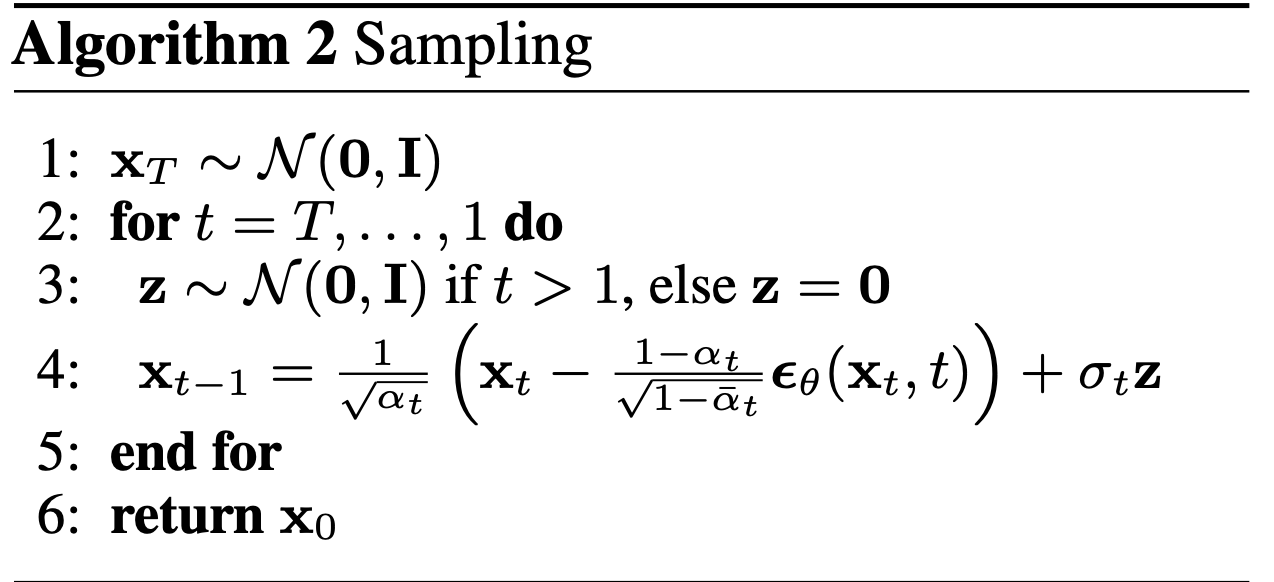

The sampling process is implemented in the __sample__ method of the class. It is basically doing the following:
1. It creates random (BATCH_SIZE, 50, 200, 3) noise images from a normal distribution.
2. It iterates through the 1000 to 0 time_steps for each of the images, at the end which should yield a meaningful CPATHCA images. The loop follows the algorithm shown in the image.
3. Atlast this images are then converted to RGB images and returned.

The rest of the function of the class are just helper functions for the __smaple method__. Please read the comments to get an overall idea.

In [11]:
class Diffusion:
    def __init__(self, noise_step = 1000, beta_start = 1e-4, beta_end = 0.02, img_size=(50, 200)):
        # Number of steps in the diffusion process
        self.noise_step = noise_step
        # Starting value for beta which is used to calculate the variance of the noise distribution
        self.beta_start = beta_start
        # Ending value for beta 
        self.beta_end = beta_end
        
        # Size of the image (50 x 200)
        self.image_size = img_size
        
        # Pre-computing some constants used in the diffusion process
        # Creating the noise schedule
        self.beta = self.prepare_noise_schedule()
        # Complement to beta
        self.alpha = 1. - self.beta
        # Cumulative product of alpha
        self.alpha_hat = tf.math.cumprod(self.alpha, axis=0)

    def prepare_noise_schedule(self):
        # Create a linearly spaced values between beta_start and beta_end
        return tf.linspace(self.beta_start, self.beta_end, self.noise_step)

    def noise_images(self, x, t):
        # Add noise to the images based on the timestep 't'
        sqrt_alpha_hat = tf.sqrt(tf.gather(self.alpha_hat, t))[:, tf.newaxis, tf.newaxis, tf.newaxis]
        sqrt_one_minus_alpha_hat = tf.sqrt(1 - tf.gather(self.alpha_hat, t))[:, tf.newaxis, tf.newaxis, tf.newaxis]
        e = tf.random.normal(shape=tf.shape(x))
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * e, e


    def sample_timestep(self,  n):
         # Randomly sample a timestep for the noise addition
        return tf.random.uniform(shape=(n,), minval=1, maxval=self.noise_step, dtype=tf.int32)

    def sample(self, model, n):
        # Set model to evaluation mode
        model.trainable = False

        with tf.GradientTape(persistent=True, watch_accessed_variables=False):
            
            # Initialize with random noise
            x = tf.random.normal((n,self.image_size[0], self.image_size[1], 3))
            
            # Reverse diffusion process from the last timestep down to the first
            for i in tf.range(self.noise_step-1, 0, -1):
                t = tf.ones(n, dtype=tf.int32) * i
                predicted_noise = model([x, t])
                
                # Gather the required alpha, alpha_hat and beta values for this timestep
                alpha = tf.reshape(tf.gather(self.alpha, t), [-1, 1, 1, 1])
                alpha_hat = tf.reshape(tf.gather(self.alpha_hat, t), [-1, 1, 1, 1])
                beta = tf.reshape(tf.gather(self.beta, t), [-1, 1, 1, 1])
                
                # Add noise except for the last step
                if i > 1:
                    noise = tf.random.normal(tf.shape(x))
                else:
                    noise = tf.zeros_like(x)
                    
                # Update the image based on the diffusion formula
                x = 1 / tf.sqrt(alpha) * (x - ((1 - alpha) / (tf.sqrt(1 - alpha_hat))) * predicted_noise) + tf.sqrt(beta) * noise

        # Set model back to training mode
        model.trainable = True
        
        # Convert the image values to be between 0 and 255
        x = tf.clip_by_value(x, -1, 1) 
        x = (x + 1) / 2
        x = tf.cast(x * 255, tf.uint8)

        return x

### Utility method for saving the sample images


This a utility method which saves the sampled images to jpg's

In [12]:
def save_images(images, path, nrow=2, padding=2):
    # Assuming images is a tensor in shape (batch, height, width, channels)
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    n_images = images.shape[0]
    grid_height = int(np.ceil(n_images / nrow))

    # Create a large canvas for the grid of images
    canvas = np.ones(((images.shape[1] + padding) * grid_height - padding,
                         (images.shape[2] + padding) * nrow - padding, 3))

    for i in range(n_images):
        row = i // nrow
        col = i % nrow
        image = images[i]
        canvas[row*(images.shape[1] + padding):row*(images.shape[1] + padding) + images.shape[1],
                col*(images.shape[2] + padding):col*(images.shape[2] + padding) + images.shape[2]] = image

    # Clip values to be in [0,1] and convert to a format suitable for saving
    ndarr = (np.clip(canvas, 0, 1) * 255).astype(np.uint8)
    im = Image.fromarray(ndarr)
    im.save(path)

### Training Function


This is the training logic of the code. The training has also been provided in the diffusion paper:
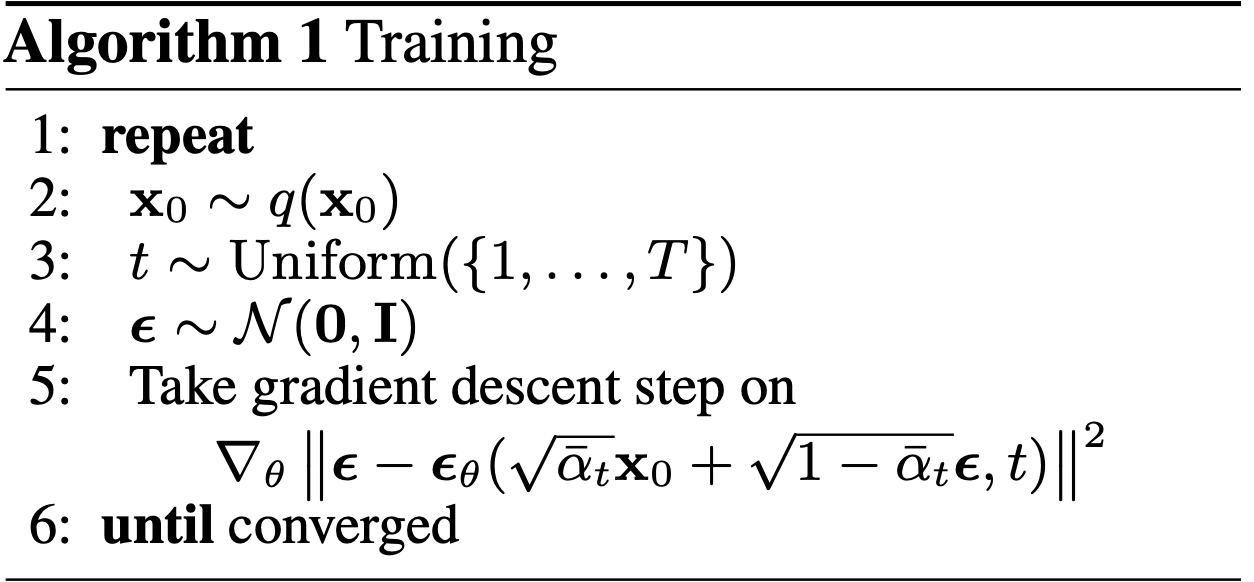


The trainig algorithm works in the following way:
1. It samples time-steps between 0 .. 1000. The time-steps sampled everytime will be equal to the BATCH_SIZE.
2. It calculates how much noise should be added to each image for the sampled time-steps, and adds the noise to the images.
3. Next the images are passsed to the model to __predict__ how much noise they have.
4. Once the the model returns the predicted amount of noise in the image, The __loss__ between the actual noise and the predicted noise is calculated using __MSE ( Mean Square Error )__.
5. Once the __loss__ is calculated, the gradients are calculated and applied to the model variables.


The above mentioned steps are scattered around in three functions below, the essential function is the __train__ function.

In [13]:
def compute_gradients(model, mse, noise, x_t, t):
    with tf.GradientTape() as tape:
        # Predict the noise for the given input using the model
        predicted_noise = model([x_t, t])
        
        # Compute the Mean Squared Error (MSE) between the predicted noise and actual noise
        loss = mse(noise, predicted_noise)
        
    # Compute the gradients of the loss with respect to the model's trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients, loss, predicted_noise

def apply_gradients(optimizer, gradients, variables):
    # Apply the computed gradients to the model's trainable variables using the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

# Strategy scope is used for GPU training
with strategy.scope():
    def train(epochs, learning_rate,  ep, load = False):
        # Initialize the U-Net model
        model = unet_model(3, 3, 256)
        
        # Load pre-trained weights if load is set to True
        if load is True:
            model.load_weights("model_weights.keras")
        
        # Initialize the optimizer with specified learning rate and other parameters
        optimizer = AdamW(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False, name='AdamW')
        
        # Define the Mean Squared Error (MSE) loss with SUM reduction
        mse = losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
        
        # Initialize the Diffusion class discussed above
        diffusion = Diffusion()
        
        # Training loop for each epoch
        for epoch in range(epochs):
            pbar = tqdm(dataset)
            
            # Loop through each batch of images in the dataset
            for i, images in enumerate(pbar):
                # Sample a timestep for the diffusion process
                t = diffusion.sample_timestep(tf.shape(images)[0])
                
                # Add noise to the images based on the timestep
                x_t, noise = diffusion.noise_images(images, t)
                
                # Use strategy.run to compute gradients
                gradients, loss, predicted_noise = strategy.run(compute_gradients, args=(model, mse, noise, x_t, t))
                
                # Use strategy.run to apply gradients
                strategy.run(apply_gradients, args=(optimizer, gradients, model.trainable_variables))

                pbar.set_postfix(MSE=loss.numpy())
        
        # Sample images using the trained model and diffusion process
        sampled_images = diffusion.sample(model, n=BATCH_SIZE)
        
        # Save the sampled images to a specified location
        save_images(sampled_images, os.path.join("diffusion_images", f"{ep}.jpg"))
        
        # Save the model's weights after training
        model.save_weights(f'model_weights.keras')

### Utility function for displaying the saved images

In [6]:
def display_image(image_path):
    # Open the image using PIL
    img = Image.open(image_path)

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # To hide axis values
    plt.show()

## Training the Model

I have trained the model using the code below for 252 epochs, then I ran out of the 30 hrs GPU limit in Kaggle. I used the following different learning rates while training with different numbers of epochs:

| Total Epochs Trained| Learning Rate |
|-----|---------|
| 10  | 3e-4 |
| 30 | 3e-4 |
| 50 | 3e-4  |
| 70 | 3e-4  |
| 100 | 3e-4  |
| 120 | 3e-4  |
| 150 | 3e-4  |
| 180 | 3e-4  |
| 200 | 3e-4  |
| 220 | 3e-5  |
| 240 | 3e-5  |
| 250 | 5e-5  |
| 252 | 5e-6  |


I will show the results of the samples produced after each trainig below and explain why I changed the learning rates. 

In [23]:
with strategy.scope():
    train(2, 5e-6, 252, True)

100%|██████████| 260/260 [04:21<00:00,  1.01s/it, MSE=319]    


### Result after training the model for the first 10 epochs

As expected the ouput is full of noise.

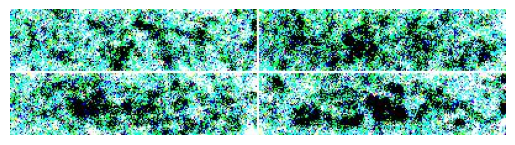

In [7]:
display_image("/kaggle/working/diffusion_images/10.jpg")

### Result after Epoch 30

After 30 epoch the model starts showing scribbles in the image.

Note: I saved the image as 20 by mistake it's name should be 30.jpg

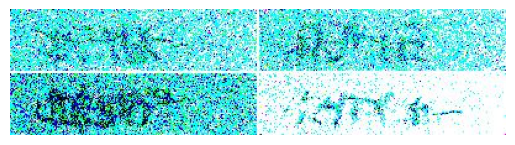

In [8]:
display_image("/kaggle/working/diffusion_images/20.jpg")

### Result after Epoch 50

The image quality downgraded in this state. But is showing red and black colors instead of blueish color like before.

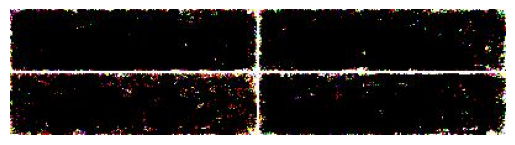

In [9]:
display_image("/kaggle/working/diffusion_images/50.jpg")

### Result after Epoch 70

The result of this epoch is quite promising, the second image is showing some meaningful letter and numbers.

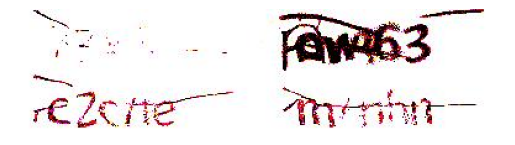

In [10]:
display_image("/kaggle/working/diffusion_images/70.jpg")

### Result after Epoch 100

The model is producing very bold letters, but still displays the many meaningful letters, the red shade from the last result seems to be gone.

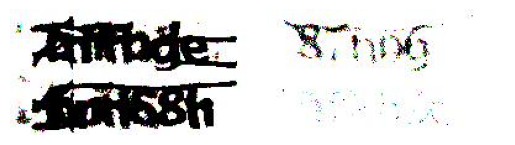

In [11]:
display_image("/kaggle/working/diffusion_images/100.jpg")

### Result after Epoch 120

In this epoch the boldness of the letter is reduced and a lot of the letters are meaning full, but some of them are still not properly visible. 

The first image is a CAPTCH with letters n6gb6. The blueish shade is back in the image.

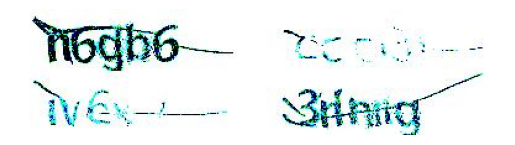

In [12]:
display_image("/kaggle/working/diffusion_images/120.jpg")

### Result after Epoch 150

The text has become bold again and the red taint is back, this sees to be a pattern but I stil ran it for two more iterations of training after this to be sure.

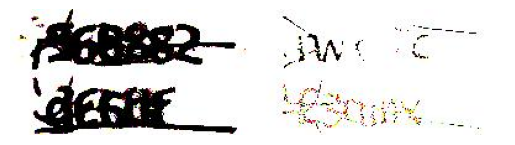

In [13]:
display_image("/kaggle/working/diffusion_images/150.jpg")

### Result after Epoch 180

The problems from the last results seemed to have been solved, but the letters and numbers are not being displayed properly.

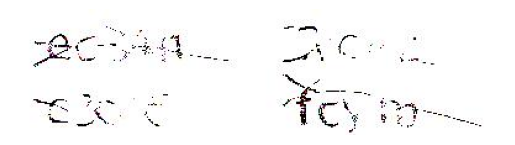

In [14]:
display_image("/kaggle/working/diffusion_images/180.jpg")

### Result after Epoch 200
The bold and pattern is reapeting, this seemed as problem with the learning rate, so I changed the learning rate to 3e-5 after this. 

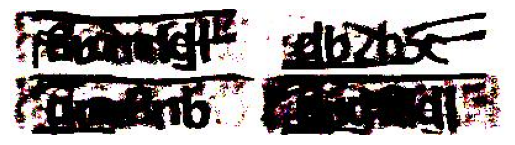

In [15]:
display_image("/kaggle/working/diffusion_images/200.jpg")

### Result after Epoch 220

The result with the new learning rate was quite close to the real CAPTCHA images, next I wanted to solve issue of fading characters.

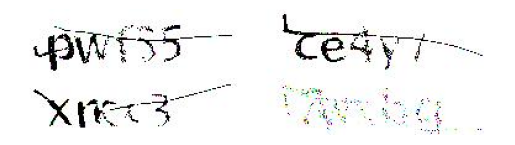

In [16]:
display_image("/kaggle/working/diffusion_images/220.jpg")

### Result after Epoch 240

I thought training the model with same learing rate of 3e-5 might solve the issue, instead the characters appear to be more faded and some of them are not visible at all.

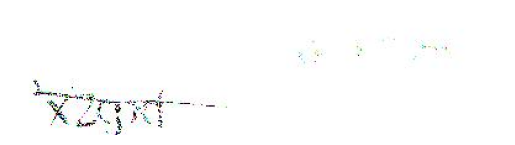

In [17]:
display_image("/kaggle/working/diffusion_images/240.jpg")

### Result after Epoch 250

Assuming the issue was the very low learning rate I changed the lr to 5e-5 instead of 3e-5. The result is better than the last one, but in the third image the characters seem to be bolding again, and the issues of fading characters and blank images still remain.

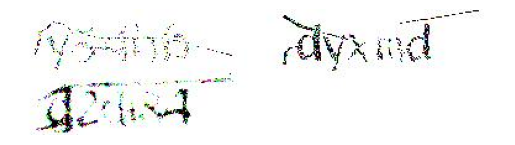

In [18]:
display_image("/kaggle/working/diffusion_images/250.jpg")

### Final Result ( Epoch 252 )

I only had training 2 epochs worth of GPU time remaining. I changed the learning rate to 5e-6 to slow down the bolding character problem. The result was half there as the images with letters in it are very close to the real CAPTCHA images, and each generated letter is meaningful,The first image reads 3cn33 and second image reads 77ndx. The problem of blank images still persists.

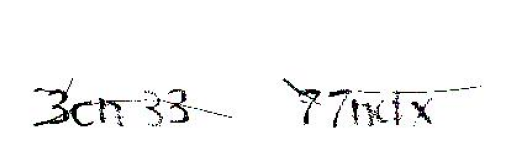

In [19]:
display_image("/kaggle/working/diffusion_images/252.jpg")

## Conclusion and Discussion

In this project, I developed a diffusion model based on the [Denoising Diffusion Probabilistic Models (DDPM)](https://arxiv.org/pdf/2006.11239.pdf) to generate CAPTCHA images. The training data was sourced from the Kaggle Dataset for CAPTCHA-v2 images. The underlying U-Net model, responsible for the diffusion process, consists of approximately 25 million parameters. Over the course of 252 epochs, the model displayed promising results.

While the final generated images bear a close resemblance to actual CAPTCHA images, there's a noticeable issue: some of the images are completely blank. This suggests the need for further experimentation to address this shortcoming. Due to limitations on Kaggle, I was constrained in terms of different experiments with the learning rate adjustments in the current model. Optimal tweaks might produce images indistinguishable from genuine CAPTCHA images.

For future iterations, I'd be inclined to explore the latent diffusion model, as adopted by the Stable Diffusion approach. This model has demonstrated superior performance compared to other diffusion models and could potentially enhance the generation of CAPTCHA images.

## References
The following tutorials and articles were very helpful for understanding and as reference implementation of Diffusion Models.

[Diffusion Models | Paper Explanation | Math Explained](https://www.youtube.com/watch?v=HoKDTa5jHvg) 
 
[Diffusion Models | PyTorch Implementation](https://www.youtube.com/watch?v=TBCRlnwJtZU) 
 
[What are Diffusion Models?](https://www.youtube.com/watch?v=fbLgFrlTnGU) 


[An In-Depth Guide to Denoising Diffusion Probabilistic Models – From Theory to Implementation](https://learnopencv.com/denoising-diffusion-probabilistic-models/)


[Introduction to Diffusion Models for Machine Learning](https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/)